# Low-Rank Approximation fine-tuning

This notebook demonstrates encrypted fine-tuning of a small MLP model with LORA. A model trained
on an initial dataset is adapted to a second dataset using LORA fine-tuning. 

The fine-tuning dataset and the LORA weights that are trained are protected using encryption. Thus, the training
can be outsourced to a remote server without leaking any sensitive data.

The hybrid model approach is applied to fine-tuning: only the linear layers of the original model are outsourced
to the server. The forward and backward passes on these original weights are performed with encrypted activations
and gradients. The LORA weights are kept by the client, and the client performs the forward and backward 
passes on the LORA weights. 

## Data preparation

Two datasets are generated: one for the original training, and a second one on which
LORA fine-tuning is performed. 

In [6]:
import shutil
from pathlib import Path

import torch
from utils.mlp_lora_module import MLPWithLoRATrainingAuto
from sklearn.datasets import make_circles, make_moons
from sklearn.model_selection import train_test_split
from utils.utils_lora import plot_decision_boundary

from concrete.ml.torch.hybrid_model import HybridFHEModel

torch.manual_seed(0)
torch.use_deterministic_algorithms(True)


N_SAMPLES = 1000


def prepare_data(X, y, test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)
    return X_train, X_test, y_train, y_test


# Generate synthetic 2D data
X1, y1 = make_moons(n_samples=N_SAMPLES, noise=0.2, random_state=42)
X2, y2 = make_circles(n_samples=N_SAMPLES, noise=0.2, factor=0.5, random_state=42)

# Prepare data
X1_train, X1_test, y1_train, y1_test = prepare_data(X1, y1)
X2_train, X2_test, y2_train, y2_test = prepare_data(X2, y2)

## Create the MLP with LORA layers

The LORA rank determines the number of total LORA weights that the model will posess. The number
of LORA weights will be much lower than the total number of weights.

In [7]:
# Initialize the model
input_size = 2
hidden_size = 128
output_size = 2
lora_rank = 1
num_epochs = 100

model = MLPWithLoRATrainingAuto(input_size, hidden_size, output_size, lora_rank=lora_rank)

# Training loop for the first task with visualization
model.train()
for epoch in range(num_epochs):
    model.optimizer.zero_grad()
    outputs = model.inference(X1_train)
    loss = model.criterion(outputs, y1_train)
    loss.backward()
    model.optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/100], Loss: 0.2349
Epoch [20/100], Loss: 0.1244
Epoch [30/100], Loss: 0.0816
Epoch [40/100], Loss: 0.0679
Epoch [50/100], Loss: 0.0607
Epoch [60/100], Loss: 0.0580
Epoch [70/100], Loss: 0.0565
Epoch [80/100], Loss: 0.0556
Epoch [90/100], Loss: 0.0549
Epoch [100/100], Loss: 0.0545


## Test the original model on the first dataset

Accuracy on the first task: 97.67%


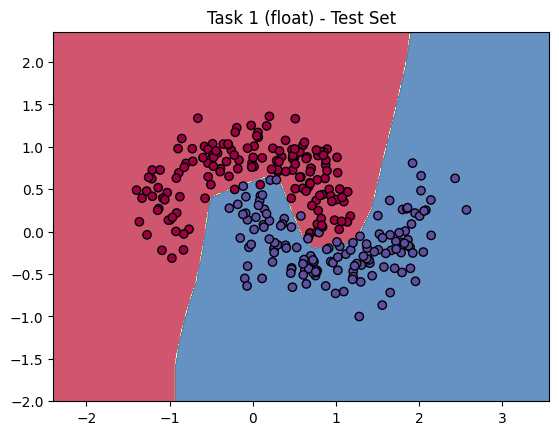

In [8]:
model.eval()
with torch.no_grad():
    outputs = model(X1_test)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y1_test).sum().item() / y1_test.size(0)
    print(f"Accuracy on the first task: {accuracy*100:.2f}%")
    plot_decision_boundary(
        model, X1_test.numpy(), y1_test.numpy(), "Task 1 (float) - Test Set", use_inference=True
    )

## Convert the original model to an FHE hybrid model with LORA layers

In [9]:
# Enable LORA layers
model.toggle_lora(enable=True)
model.train()

# Create the FHE compatible model, outsourcing all linear layers
hybrid_model = HybridFHEModel(model, ["fc1", "fc2.forward_module", "fc2.backward_module"])

# Sample some data to determine the weight and activation value bounds for training
inputset_sample = 100
x_train_mixed = torch.cat((X1_train[:inputset_sample], X2_train[:inputset_sample]), dim=0)
y_train_mixed = torch.cat((y1_train[:inputset_sample], y2_train[:inputset_sample]), dim=0)
inputset = (x_train_mixed, y_train_mixed)

# Compile the model to use FHE
hybrid_model.compile_model(inputset, n_bits=8)


## Test the FHE model on the original dataset

FHE Accuracy on the first task: 97.67%


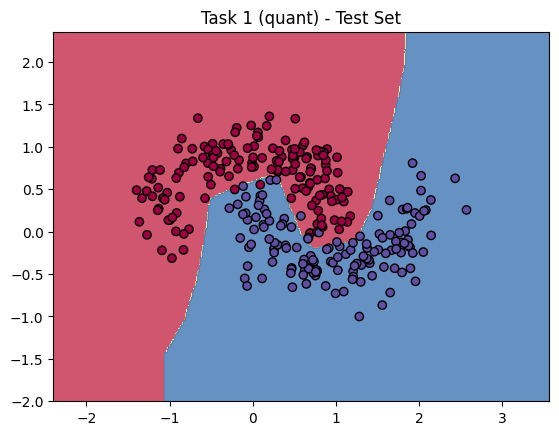

In [10]:
hybrid_model.model.toggle_lora(enable=False)
hybrid_model.model.eval()

with torch.no_grad():
    outputs = hybrid_model(X1_test, fhe="execute")
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y1_test).sum().item() / y1_test.size(0)
    print(f"FHE Accuracy on the first task: {accuracy*100:.2f}%")
    plot_decision_boundary(
        hybrid_model,
        X1_test.numpy(),
        y1_test.numpy(),
        "Task 1 (quant) - Test Set",
        use_inference=False,
    )

## Train the model on the second dataset

For now, the LORA weights are not trained and are thus simply randomly intitialized. It is 
now time to enable the LORA weights and fine-tune them on the second dataset. 

In [11]:
hybrid_model.model.toggle_lora(enable=True)
hybrid_model.model.train()

LORA_SAMPLES = 50

X2_train_lora = X2_train[:LORA_SAMPLES]
y2_train_lora = y2_train[:LORA_SAMPLES]

num_epochs = 40
for epoch in range(num_epochs):
    loss = hybrid_model((X2_train_lora, y2_train_lora), fhe="execute")
    if epoch % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/40], Loss: 0.8596
Epoch [6/40], Loss: 0.4767
Epoch [11/40], Loss: 0.3264
Epoch [16/40], Loss: 0.2809
Epoch [21/40], Loss: 0.2605
Epoch [26/40], Loss: 0.2325
Epoch [31/40], Loss: 0.2219
Epoch [36/40], Loss: 0.2172


## Evaluate the fine-tuned model on the second dataset

Accuracy on the second task: 81.33%


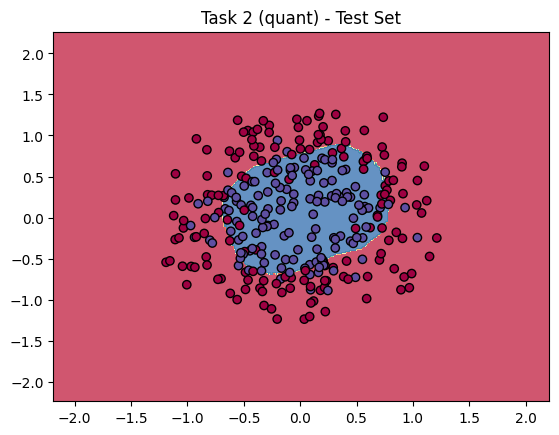

In [12]:
hybrid_model.model.toggle_lora(True)
hybrid_model.model.eval()

with torch.no_grad():
    outputs = hybrid_model(X2_test, fhe="execute")
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y2_test).sum().item() / y2_test.size(0)
    print(f"Accuracy on the second task: {accuracy*100:.2f}%")
    plot_decision_boundary(
        hybrid_model,
        X2_test.numpy(),
        y2_test.numpy(),
        "Task 2 (quant) - Test Set",
    )

## Check the model without LORA weights on the original dataset

When running without the LORA weights you should get the same result as 
as the original model (in FHE).

Accuracy on the second task: 97.67%


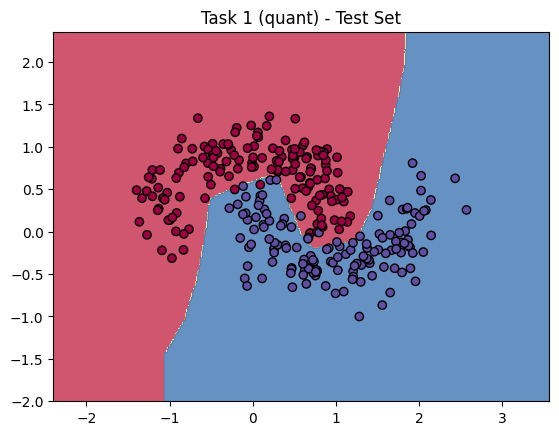

In [13]:
hybrid_model.model.toggle_lora(False)
hybrid_model.model.eval()

with torch.no_grad():
    outputs = hybrid_model(X1_test, fhe="execute")
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y1_test).sum().item() / y1_test.size(0)
    print(f"Accuracy on the second task: {accuracy*100:.2f}%")
    plot_decision_boundary(
        hybrid_model,
        X1_test.numpy(),
        y1_test.numpy(),
        "Task 1 (quant) - Test Set",
    )

## Compute the percentage of LORA weights

First, check the total number of weights in the model.

In [14]:
total_weights = 0
for name, param in hybrid_model.model.named_parameters():
    total_weights += param.numel()
    print(name, param.numel())

print(f"Total number of weights: {total_weights}")

fc1.private_module.weight 256
fc1.private_module.bias 128
fc1_lora.A 128
fc1_lora.B 2
fc2.forward_module.private_module.weight 256
fc2.forward_module.private_module.bias 2
fc2_lora.A 2
fc2_lora.B 128
Total number of weights: 902


Remove the weights that are outsourced to the server-side. These weights
are not needed on the client, providing computation time and memory savings. 

In [15]:
path = Path("lora_mlp")

if path.is_dir() and any(path.iterdir()):
    shutil.rmtree(path)

hybrid_model.save_and_clear_private_info(path)

Compute the number of LORA weights

In [16]:
total_lora_weights = 0
for name, param in hybrid_model.model.named_parameters():
    total_lora_weights += param.numel()
    print(name, param.numel())

print(f"Total number of weights: {total_lora_weights}")

fc1_lora.A 128
fc1_lora.B 2
fc2_lora.A 2
fc2_lora.B 128
Total number of weights: 260


In [17]:
print(f"Percentage of LORA weights out of the total: {total_lora_weights/total_weights*100:.2f}%")

Percentage of LORA weights out of the total: 28.82%


## Conclusion

LORA parameter-efficient fine-tuning helps fine-tune private models on private data. The server, which 
computes activations and gradient using the original weights, has no access to the private training data:
the activations and gradients are encrypted by the client and stay secret.

The example here shows LORA for an MLP model on low-dimensional data. The percentage of LORA weights is comparatively
high with respect to a bigger model such as a transformer or LLM. In practice for an LLM the number of LORA 
weights stays under one percent of total weights. Thus the client device has low memory and computation requirements.